In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#  Missing value analysis

In [3]:
train.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [4]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

**We can see that there are no missing values in our data set**

In [5]:
#removing of id column as it is not of use for our analysis and model building
train.drop('id',axis=1,inplace=True)
test.drop('id',inplace=True,axis=1)

# Checking duplicate data

In [6]:
train_duplicate = train[train.duplicated('comment_text',keep='first')]
train_duplicate

Empty DataFrame
Columns: [comment_text, malignant, highly_malignant, rude, threat, abuse, loathe]
Index: []

In [7]:
test_duplicate = test[test.duplicated('comment_text',keep='first')]
test_duplicate

Empty DataFrame
Columns: [comment_text]
Index: []

**We can see that there are no duplicate values in our data set**

### Visualizing the length of comments

In [8]:
train.head()

comment_text  malignant  \
0  Explanation\nWhy the edits made under my usern...          0   
1  D'aww! He matches this background colour I'm s...          0   
2  Hey man, I'm really not trying to edit war. It...          0   
3  "\nMore\nI can't make any real suggestions on ...          0   
4  You, sir, are my hero. Any chance you remember...          0   

   highly_malignant  rude  threat  abuse  loathe  
0                 0     0       0      0       0  
1                 0     0       0      0       0  
2                 0     0       0      0       0  
3                 0     0       0      0       0  
4                 0     0       0      0       0

average length of comment: 394.139


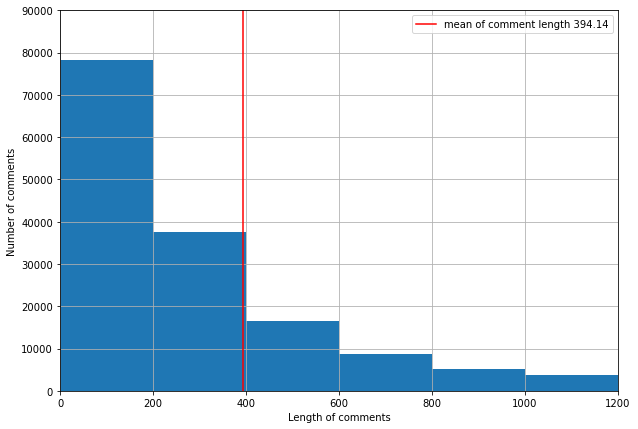

In [9]:
x = []

'''
Below code will extract the len of every single comment including space in the comment and then it will
be transfered to x variable in a list format
'''

for i in range(len(train)):
    x.append(len(train['comment_text'][i]))
    

print('average length of comment: {:.3f}'.format(sum(x)/len(x)))

'''
Below code will make a histrogram which will show comment length on x-axis and
number of comments on y-axis
'''

plt.figure(figsize=(10,7))
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.axvline(x = sum(x)/len(x), color = 'r', label = 'mean of comment length {:.2f}'.format(sum(x)/len(x)))
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.legend()
plt.show()

**from the above plot we can observe that most of the comments having words ranging from 0-200 words.
As the length of comment increases number of comment decreases**

In [10]:
#checking how many comments are there which are not labelled as malignant,highly_malignant,rude,threat,abuse,loathe

'''
Below comment will extract all the observation where each target variable having 0 value,
those observation will be classified as non-malignant

'''

unlaballed_comment = train[(train['malignant']!=1) &
                          (train['highly_malignant']!=1) &
                          (train['rude']!=1) &
                          (train['threat']!=1) &
                          (train['abuse']!=1) &
                          (train['loathe']!=1)]

In [11]:
print("Percentage of non-malignant comments we have in our data set is: {}".format((len(unlaballed_comment)/train.shape[0])*100))

Percentage of non-malignant comments we have in our data set is: 89.83211235124176


In [12]:
print('total comments without any label are {}'.format(len(unlaballed_comment)))
print('total comments with labels are {}'.format(train.shape[0]-len(unlaballed_comment)))

total comments without any label are 143346
total comments with labels are 16225


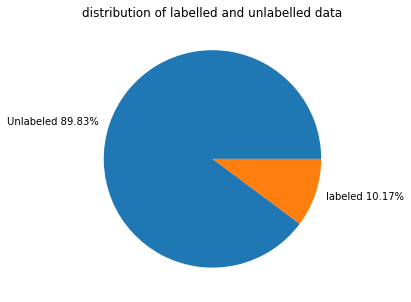

In [13]:
y = [143346,16225]
plt.figure(figsize=(8,5))
plt.pie(y,labels=['Unlabeled {:.2f}%'.format((len(unlaballed_comment)/train.shape[0])*100),'labeled {:.2f}%'.format((16225/train.shape[0])*100)])
plt.title('distribution of labelled and unlabelled data')
plt.show()

**From the above analysis / visualisation we can see that our data is highly imbalanced**

### Finding the frequency of labelled data

**I will check how many comments are having 1,2,3,4,and 5 labels respectively.**

In [14]:
label = train[['malignant','highly_malignant','rude','threat','abuse','loathe']]

label.head()
label=label.to_numpy()

**ct stands for comment tags**

- ct1 = comment with 1 tag
- ct2 = comment with 2 tags
- ct3 = comment with 3 tags
- ct4 = comment with 4 tags
- ct5 = comment with 5 tags
- ct6 = comment with 6 tags

In [15]:
c_t = []

ct0,ct1,ct2,ct3,ct4,ct5,ct6 = 0,0,0,0,0,0,0

for i in range(label.shape[0]):
    ct = np.count_nonzero(label[i])
    if ct == 0:
        ct0 = ct0+1
    if ct == 1:
        ct1 = ct1+1
    if ct == 2 :
        ct2 = ct2+1
    if ct == 3 :
        ct3 = ct3+1
    if ct == 4 :
        ct4 = ct4+1
    if ct == 5 :
        ct5 = ct5+1
    if ct == 6 :
        ct6 = ct6+1
        
    
print(ct0)
c_t.append(ct0)

print(ct1)
c_t.append(ct1)

print(ct2)
c_t.append(ct2)

print(ct3)
c_t.append(ct3)

print(ct4)
c_t.append(ct4)

print(ct5)
c_t.append(ct5)

print(ct6)
c_t.append(ct6)


143346
6360
3480
4209
1760
385
31


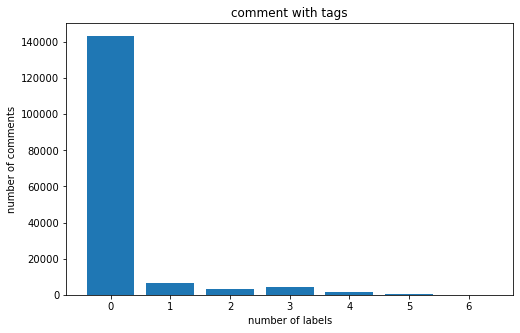

In [16]:
plt.figure(figsize=(8,5))
plt.bar(range(7),c_t)
plt.title('comment with tags')
plt.xlabel('number of labels')
plt.ylabel('number of comments')
plt.show()

**From the above plot we can see that the number of comments without any tag are exponentially more than from the comments having tags, it shows that the data we have is imbalanced, we have very less data where comments is having any tag. There are 31 comments which are having all the 6 tags**

# Data Cleaning

In [17]:
def clean_text(review):
    for i in range(len(train)):
        review = re.sub('[^a-zA-Z]', ' ',review) #replacing all non alpha charcaters with space
        
        review = re.sub('\[|\]', ' ', review)   #replacing brackets
        review = re.sub('https?://\S+|www\.\S+', '', review)  #removing htlm tags
        review = re.sub('\n', '', review)         #replacing next line spaces
        review = re.sub(' +|_+', ' ', review)   #replacing multiple line spaces and _ with single space bar only
        review = re.sub('n\st',' not',review)  #for characters like aren't I will replace n't with not
        review = review.lower() #lower case
        return review

In [18]:
train['comment_text'] = train['comment_text'].apply(clean_text)

In [19]:
#cleaning the validation data as well

test['comment_text'] = test['comment_text'].apply(clean_text)

In [20]:
train.to_csv('train_cleaned.csv')
test.to_csv('test_cleaned.csv')

In [21]:
print("shape of train data:",train.shape)
print("shape of test data: ", test.shape)

shape of train data: (159571, 7)
shape of test data:  (153164, 1)
